# Create a voucher geojson with demographic data 

This notebook filters ZCTA shapefiles to the Phoenix metro area, which is Maricopa and Pinal counties, and merges it with Section 8 voucher data that is merged with Census demographic info.

## Data Sources

2020 Zip Code Tabulation Area shapefile (national): https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
<br>
<br>
HUD crosswalk data ZIP-COUNTY: https://www.huduser.gov/portal/datasets/usps_crosswalk.html
<br>
<br>
Section 8 vouchers by zip code (metro Phoenix): Requested from seven public housing authorities. Data is as of April 1, 2022.
<ul>
    <li>Maricopa County</li>
    <li>Phoenix</li>
    <li>Mesa</li>
    <li>Glendale</li>
    <li>Scottsdale</li>
    <li>Tempe</li>
    <li>Chandler (does not have vouchers by zipcode)</li>
</ul>
Census demographic data by ZCTA for AZ:
<ul>
    <li>B17020 Poverty Status in the Past 12 Months by Age</li>
    <li>B19013 Median Household Income in the Past 12 Months</li>
</ul>

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib

### Load shapefile data

In [4]:
zipfile = '/Users/amyqin/Documents/data/source/tl_2021_us_zcta520.zip'

In [5]:
zctas = gpd.read_file(zipfile)

In [6]:
zctas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33791 entries, 0 to 33790
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ZCTA5CE20   33791 non-null  object  
 1   GEOID20     33791 non-null  object  
 2   CLASSFP20   33791 non-null  object  
 3   MTFCC20     33791 non-null  object  
 4   FUNCSTAT20  33791 non-null  object  
 5   ALAND20     33791 non-null  int64   
 6   AWATER20    33791 non-null  int64   
 7   INTPTLAT20  33791 non-null  object  
 8   INTPTLON20  33791 non-null  object  
 9   geometry    33791 non-null  geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 2.6+ MB


In [5]:
#insepct loaded data
zctas.head()

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,47236,47236,B5,G6350,S,1029067,0,+39.1517426,-085.7252769,"POLYGON ((-85.73410 39.15597, -85.72749 39.156..."
1,47870,47870,B5,G6350,S,8830,0,+39.3701518,-087.4735141,"POLYGON ((-87.47414 39.37016, -87.47409 39.370..."
2,47851,47851,B5,G6350,S,53547,0,+39.5735818,-087.2459626,"POLYGON ((-87.24770 39.57431, -87.24770 39.574..."
3,47337,47337,B5,G6350,S,303089,0,+39.8027537,-085.4372850,"POLYGON ((-85.44357 39.80328, -85.44346 39.803..."
4,47435,47435,B5,G6350,S,13302,0,+39.2657557,-086.2951577,"POLYGON ((-86.29592 39.26547, -86.29592 39.266..."


<AxesSubplot:>

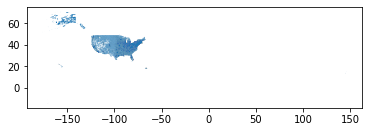

In [6]:
zctas.plot()

In [7]:
#check projection
zctas.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

### Load HUD data

Load and filter for only metro Phoenix, which is Maricopa county = 04013 and Pinal county = 04021

In [7]:
hud = pd.read_excel('/Users/amyqin/Documents/data/source/ZIP_COUNTY_122021.xlsx')

In [8]:
hud.head()

,zip,county,usps_zip_pref_city,usps_zip_pref_state,res_ratio,bus_ratio,oth_ratio,tot_ratio
0,683,72125,SAN GERMAN,PR,0.953036,0.996656,0.980769,0.956300
1,683,72079,SAN GERMAN,PR,0.000949,0.000000,0.000000,0.000873
2,683,72023,SAN GERMAN,PR,0.000791,0.001115,0.000000,0.000800
3,683,72097,SAN GERMAN,PR,0.000158,0.000000,0.000000,0.000145
4,683,72121,SAN GERMAN,PR,0.045066,0.002230,0.019231,0.041882


In [9]:
metrophx_zips = hud.query('county == 4013 or county == 4021')

In [10]:
metrophx_zips.shape

(228, 8)

### Create metro Phoenix zipcode shapefile

In [11]:
#convert ZCTA to integer
zctas['ZCTA5CE20'] = zctas['ZCTA5CE20'].astype(int)

In [12]:
#right merge
metrophx_zips_shp = zctas.merge(metrophx_zips, left_on='ZCTA5CE20', right_on='zip', how = 'right')

In [35]:
metrophx_zips_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 228 entries, 0 to 227
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ZCTA5CE20            175 non-null    float64 
 1   GEOID20              175 non-null    object  
 2   CLASSFP20            175 non-null    object  
 3   MTFCC20              175 non-null    object  
 4   FUNCSTAT20           175 non-null    object  
 5   ALAND20              175 non-null    float64 
 6   AWATER20             175 non-null    float64 
 7   INTPTLAT20           175 non-null    object  
 8   INTPTLON20           175 non-null    object  
 9   geometry             175 non-null    geometry
 10  zip                  228 non-null    int64   
 11  county               228 non-null    int64   
 12  usps_zip_pref_city   228 non-null    object  
 13  usps_zip_pref_state  228 non-null    object  
 14  res_ratio            228 non-null    float64 
 15  bus_ratio      

In [14]:
#check
metrophx_zips_shp.shape

(228, 18)

In [15]:
metrophx_zips_shp.head()

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,zip,county,usps_zip_pref_city,usps_zip_pref_state,res_ratio,bus_ratio,oth_ratio,tot_ratio
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,85252,4013,SCOTTSDALE,AZ,1.0,1.0,1.0,1.0
1,85013.0,85013,B5,G6350,S,9543731.0,21662.0,+33.5111125,-112.0847312,"POLYGON ((-112.09137 33.48171, -112.09137 33.4...",85013,4013,PHOENIX,AZ,1.0,1.0,1.0,1.0
2,85128.0,85128,B5,G6350,S,431633755.0,4493906.0,+32.9628436,-111.5096876,"POLYGON ((-111.67274 33.04917, -111.66997 33.0...",85128,4021,COOLIDGE,AZ,1.0,1.0,1.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,85275,4013,MESA,AZ,1.0,1.0,1.0,1.0
4,85320.0,85320,B5,G6350,S,703826694.0,0.0,+33.8355753,-113.2322010,"POLYGON ((-113.33507 33.70464, -113.33507 33.7...",85320,4013,AGUILA,AZ,1.0,0.0,1.0,1.0


### Load voucher data

Note about data: zip codes that appear multiple times means those zip codes are in more than one PHA.

In [16]:
vouchers = pd.read_csv('/Users/amyqin/Documents/data/processed/vouchers.csv')

In [17]:
vouchers.shape

(144, 3)

In [18]:
vouchers.head()

,Zip code,PHA,Number of vouchers
0,85301,Glendale,620
1,85041,Phoenix,568
2,85015,Phoenix,463
3,85201,Mesa,429
4,85008,Phoenix,418


In [19]:
vouchers.groupby('PHA')['Number of vouchers'].sum()

PHA
Glendale           1194
Maricopa County    1324
Mesa               1446
Phoenix            6152
Scottsdale          569
Tempe               870
mesa                241
Name: Number of vouchers, dtype: int64

### Load Census data and merge with voucher data

In [20]:
#percent below poverty 
below_poverty = pd.read_csv('/Users/amyqin/Documents/data/processed/percent_below_poverty_AZ_ZCTA_2020_census/ACSDT5Y2020.B17020_data_with_overlays_2022-06-13T200643.csv',
                           skiprows = 1)

#median income
median_income = pd.read_csv('/Users/amyqin/Documents/data/processed/median_household_income_ZCTA_AZ_2020_census/ACSDT5Y2020.B19013_data_with_overlays_2022-04-26T202138.csv',
                            skiprows = 1)

In [21]:
#calculate percent below poverty by zip
below_poverty['pct_below_poverty'] = below_poverty['Estimate!!Total:!!Income in the past 12 months below poverty level:']/below_poverty['Estimate!!Total:']

In [22]:
#clean up dataframes

#create a list of column numbers to drop for below_poverty
cols = list(range(0,36))

#drop all irrelevant columns
below_poverty.drop(below_poverty.columns[cols],axis=1,inplace=True)

#clean up income dataframe
cols = [1,2,3]
median_income.drop(median_income.columns[cols],axis=1,inplace=True)

#rename median income column
median_income.rename(columns={'Estimate!!Median household income in the past 12 months (in 2020 inflation-adjusted dollars)':'median_income'}, inplace=True)

In [ ]:
#make merges on zipcode
vouchers = pd.merge(vouchers,below_poverty[['ZIPCODE','pct_below_poverty']],how='left',left_on='Zip code',right_on='ZIPCODE')
vouchers = pd.merge(vouchers,median_income[['ZIPCODE','median_income']],how='left',left_on='Zip code',right_on='ZIPCODE')

In [24]:
del vouchers['ZIPCODE_x']
del vouchers['ZIPCODE_y']

In [25]:
vouchers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Zip code            144 non-null    int64  
 1   PHA                 144 non-null    object 
 2   Number of vouchers  144 non-null    int64  
 3   pct_below_poverty   135 non-null    float64
 4   median_income       135 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 6.8+ KB


In [58]:
vouchers.tail(10)

,Zip code,PHA,Number of vouchers,pct_below_poverty,median_income
134,85261,Scottsdale,1,NaN,NaN
135,85211,Maricopa County,1,NaN,NaN
136,85293,Maricopa County,1,NaN,NaN
137,85343,Maricopa County,1,0.000000,-
138,85391,Maricopa County,1,NaN,NaN
139,85393,Maricopa County,1,NaN,NaN
140,85281,Tempe,445,0.328552,42545
141,85282,Tempe,304,0.133355,61700
142,85283,Tempe,114,0.153312,65738
143,85284,Tempe,7,0.035083,127500


In [26]:
#some of the zip codes are duplicates because mutliple PHA's cover them
print(vouchers.duplicated(subset='Zip code').sum())

22


In [27]:
#consolidate by unique zip code
vouchers_grouped = vouchers.groupby(by=['Zip code']).agg({'Number of vouchers':'sum','pct_below_poverty':'first','median_income':'first'})

In [28]:
#make sure zip code doesn't become an index column
vouchers_grouped.reset_index(inplace=True)

In [29]:
vouchers_grouped.head()

,Zip code,Number of vouchers,pct_below_poverty,median_income
0,85003,132,0.192122,48306
1,85004,10,0.282776,52000
2,85006,259,0.296541,43567
3,85007,196,0.312386,35642
4,85008,418,0.210148,46724


In [30]:
#check to make sure duplicates are out
vouchers_grouped.shape

(122, 4)

In [41]:
print(vouchers_grouped.duplicated(subset='Zip code').sum())

0


In [32]:
#check sum = 11,796
vouchers_grouped['Number of vouchers'].sum()

11796

In [34]:
vouchers_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Zip code            122 non-null    int64  
 1   Number of vouchers  122 non-null    int64  
 2   pct_below_poverty   113 non-null    float64
 3   median_income       113 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 3.9+ KB


### Merge vouchers with geopandas

Merge vouchers_grouped with metrophx_zips_shp. There are some zip codes in the voucher data that don't exist in the census zip codes. Then export it to a geojson to use in a mapping software. 
<br>
Note: There are some duplicate zip codes in the metrophx_zips_shp file, but it should not matter for mapping. 

In [52]:
#check the zip codes that are in vouchers_grouped but not in metrophx_zips_shp
set(vouchers_grouped['Zip code']).difference(set(metrophx_zips_shp['zip']))

{85220, 85293, 85321, 85325, 85346, 85347, 85357, 85391, 85393, 86363}

In [43]:
#outer join
vouchers_shp = metrophx_zips_shp.merge(vouchers_grouped,how='outer',left_on='zip',right_on='Zip code')

In [54]:
#check if there are duplicates
metrophx_zips_shp.groupby('zip').size().sort_values(ascending=False)

zip
85142    2
85212    2
85143    2
85120    2
85119    2
        ..
85130    1
85131    1
85132    1
85137    1
85739    1
Length: 221, dtype: int64

In [55]:
#print all the duplicate zips
metrophx_zips_shp.groupby('zip').size()[lambda x: x > 1] #inline function to return whether every item in the series is greater than 1

zip
85119    2
85120    2
85139    2
85142    2
85143    2
85212    2
85248    2
dtype: int64

In [49]:
vouchers_grouped[vouchers_grouped['Zip code']==85086]

,Zip code,Number of vouchers,pct_below_poverty,median_income
40,85086,49,0.03337,103122


In [50]:
vouchers_shp[vouchers_shp['Zip code']==85086]

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,...,usps_zip_pref_city,usps_zip_pref_state,res_ratio,bus_ratio,oth_ratio,tot_ratio,Zip code,Number of vouchers,pct_below_poverty,median_income
149,85086.0,85086,B5,G6350,S,158882534.0,112677.0,+33.8225147,-112.1302858,"POLYGON ((-112.24163 33.80515, -112.24142 33.8...",...,PHOENIX,AZ,1.0,1.0,1.0,1.0,85086.0,49.0,0.03337,103122


In [110]:
vouchers_shp.shape

(238, 22)

In [112]:
vouchers_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 238 entries, 0 to 237
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ZCTA5CE20            175 non-null    float64 
 1   GEOID20              175 non-null    object  
 2   CLASSFP20            175 non-null    object  
 3   MTFCC20              175 non-null    object  
 4   FUNCSTAT20           175 non-null    object  
 5   ALAND20              175 non-null    float64 
 6   AWATER20             175 non-null    float64 
 7   INTPTLAT20           175 non-null    object  
 8   INTPTLON20           175 non-null    object  
 9   geometry             175 non-null    geometry
 10  zip                  228 non-null    float64 
 11  county               228 non-null    float64 
 12  usps_zip_pref_city   228 non-null    object  
 13  usps_zip_pref_state  228 non-null    object  
 14  res_ratio            228 non-null    float64 
 15  bus_ratio      

In [ ]:
#can also export geodataframe to pandas to inspect
#https://stackoverflow.com/questions/49504886/converting-a-geopandas-geodataframe-into-a-pandas-dataframe/49505622#49505622

In [95]:
#This is okay for the map, because of duplicates 73 more vouchers
vouchers_shp['Number of vouchers'].sum()

11869.0

In [82]:
vouchers_shp.query('zip == 85301')

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,...,county,usps_zip_pref_city,usps_zip_pref_state,res_ratio,bus_ratio,oth_ratio,tot_ratio,Number of vouchers,pct_below_poverty,median_income
78,85301.0,85301,B5,G6350,S,24118695.0,5291.0,+33.5337295,-112.1785400,"MULTIPOLYGON (((-112.20736 33.53680, -112.2073...",...,4013.0,GLENDALE,AZ,1.0,1.0,1.0,1.0,621.0,0.311492,38454


### Export vouchers data merged w/ census data into a csv

In [59]:
#save in my data folder
vouchers_grouped.to_csv("/Users/amyqin/Documents/data/processed/vouchers_census_data.csv", index=False)